## Storage

Azure provide [many options](https://azure.microsoft.com/en-us/product-categories/storage/) for storing data. For cloud-native workflows favored by the Planetary Computer, [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-blobs-introduction) is a good choice. In this example we'll compute NDVI for a single image and write the results to a container in Azure Blob Storage as a single-band COG. Note that your storage and compute should be located in the same [Azure region](https://azure.microsoft.com/en-us/global-infrastructure/geographies/). The Planetary Computer Hub and data reside in the West Europe region.

### Compute NDVI

We need something to write. To simulate a workload, let's load in a single [NAIP image](../datasets/naip/naip-example.ipynb) from the Planetary Computer's data catalog using [rioxarray](https://corteva.github.io/rioxarray/html/rioxarray.html) and compute the NDVI using [xrspatial](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.ndvi.html).

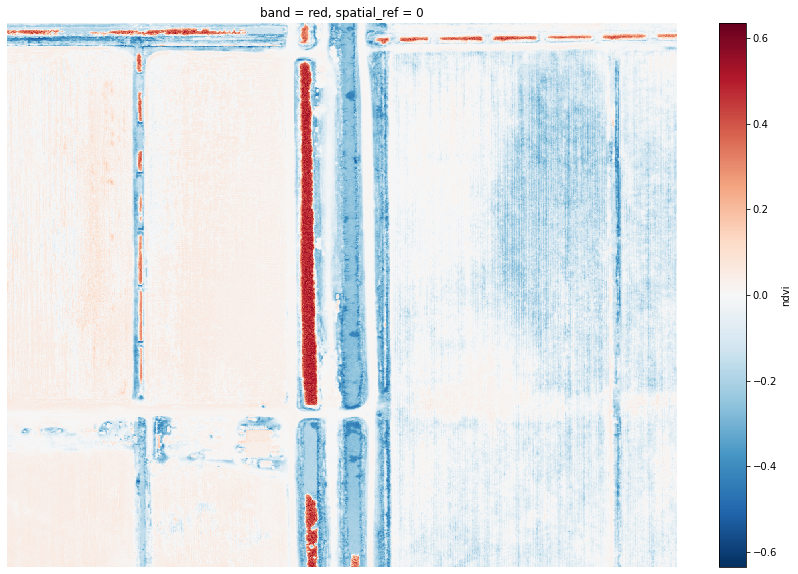

In [1]:
import matplotlib.pyplot as plt
import planetary_computer
import pystac
import rioxarray
import xrspatial


item = pystac.Item.from_file(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
    "collections/naip/items/fl_m_2608005_nw_17_060_20191215_20200113"
)
url = planetary_computer.sign(item.assets["image"].href)
ds = (
    rioxarray.open_rasterio(url)
    .assign_coords(band=["red", "green", "blue", "nir"])
    .load()
    .astype(float)
)


ndvi = xrspatial.ndvi(ds.sel(band="red"), ds.sel(band="nir"))

fig, ax = plt.subplots(figsize=(15, 10))
ndvi.isel(y=slice(1000), x=slice(1000)).plot.imshow(ax=ax)
ax.set_axis_off()

### Write to Azure Blob Storage

Now we'll use the `azure.storage.blob` Python library to write this data to blob storage.

In this case we'll write to the `pc-scratch` *container* in the `pcstoraccount` *storage account*. This is a private container so we need to somehow authorize the access to the storage account. There are [several ways](https://docs.microsoft.com/en-us/azure/storage/common/storage-auth?toc=/azure/storage/blobs/toc.json) to achieve this, but we'll make a [ContainerClient](https://docs.microsoft.com/en-us/python/api/azure-storage-blob/azure.storage.blob.containerclient?view=azure-python) using a connection string, which you can get from the Azure Portal. This connection string is private, so we'll securely transfer it using `getpass.getpass`. To write data to your own container you would provide your own connection string and container name.

In [2]:
import getpass
import azure.storage.blob

connection_string = getpass.getpass()  # prompts for the connection string
container_client = azure.storage.blob.ContainerClient.from_connection_string(
    connection_string, container_name="pc-scratch"
)

 ····························································································································································································


Now we're ready to write the `ndvi` data to a single-band COG and upload that to Blob Storage. We write data to an in-memory `io.BytesIO` buffer, which can be uploaded to Azure Blob Storage with `container_client.upload_blob`.

In [3]:
import io

with io.BytesIO() as buffer:
    ndvi.rio.to_raster(buffer, driver="COG")
    buffer.seek(0)
    blob_client = container_client.get_blob_client("ndvi-wb.tif")
    blob_client.upload_blob(buffer, overwrite=True)

Now the data is available in Azure Blob Storage, in our private storage container. To read the data, we use the same connection string, or generate a read-only [SAS token](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) and attach it to the URL of the blob. This lets tools like `rasterio` and `rioxarray` open the data without having to download it locally.

In [4]:
import urllib.parse

sas_token = azure.storage.blob.generate_blob_sas(
    container_client.account_name,
    container_client.container_name,
    blob_client.blob_name,
    account_key=container_client.credential.account_key,
    permission=["read"],
)
url = blob_client.url + "?" + urllib.parse.quote_plus(sas_token)

rioxarray.open_rasterio(url)

<xarray.DataArray (band: 1, y: 12250, x: 11050)>
[135362500 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.494e+05 5.494e+05 5.494e+05 ... 5.56e+05 5.56e+05
  * y            (y) float64 2.987e+06 2.987e+06 ... 2.979e+06 2.979e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ndvi

### Next Steps

For more on Azure Blob Storage, see the [Python quickstart](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-quickstart-blobs-python) and the [general introduction to Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-blobs-introduction). For more on the tools used in this example, see the documentation for [rioxarray](https://corteva.github.io/rioxarray/html/rioxarray.html), [xarray](https://xarray.pydata.org/en/stable/), and [rasterio](https://rasterio.readthedocs.io/en/latest/), and [xarray-spatial](https://xarray-spatial.org/).